<a href="https://colab.research.google.com/github/arieles08/TP1_DMCyT/blob/main/TP1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##      **TP1**
#                2do cuatrimestre 2022 

**Clustering de Imágenes**

### Librerias y Paquetes

In [1]:
#1 for loading/processing the images:
#from keras.preprocessing.image import load_img  
#from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.utils  import load_img
from tensorflow.keras.utils import img_to_array

#2 models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

#3 clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#3 for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import random
#import pickle

In [ ]:
#Agrego scikit learn extra para el script de PAM
!pip install git+https://github.com/scikit-learn-contrib/scikit-learn-extra.git

### Definición de Funciones

In [2]:
#1° Descarga Modelo de Redes Neuronales Convolucionales pre-entrenado VGG16 con 16 capas, para Transfer Learning:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

553467096/553467096 [==============================] - 3s 0us/step


In [4]:
#2° -> redimensiona a imagenes a 224x224 -> las redimensiona a un arrar
def extract_features(file, model):
    # levanta imagen como array 224x224 
    img = load_img(file, target_size=(224,224))
    # convierte img a numpy array (originalmente es 'PIL.Image.Image') 
    img = np.array(img) 
    # reshape para tener formato necesario para el modelo (num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepara imagen para modelo (función de keras)
    imgx = preprocess_input(reshaped_img)
    # extrae features
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [3]:
#3° 
def preprocess(lista, model):
    datays = {}
    for i in lista:
      featuress = extract_features(i, model)
      datays[i] = featuress               
    # lista de filenames
    filenmss = np.array(list(datays.keys()))
    
    # lista de features
    featsss = np.array(list(datays.values()))

    # reshape 4096 features por el número de imagens 
    featsss = featsss.reshape(-1,4096)
    return filenmss, featsss

In [5]:
#extra: Funcion para visualizar clusters (independiente de 1,2y3)
def view_cluster(gps,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = gps
    # only allow up to 30 images to be shown at a time
    if len(files) > 10:
        print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(1,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.title('Cluster n:' + str(cluster))
        plt.axis('off')

# 0.**Preparación de los datos**

### (a) Levantar las imágenes y sus etiquetas.
### (b) Documentar las propiedades del dataset a utilizar.
### (c) Describir sus atributos, de forma semejante a lo realizado en el pre-informe.
### (b) Documentar las propiedades del dataset a utilizar.

#### Carga del dataset **Total** de imagenes (path + crear etiquetas): 

In [6]:
#Acceso a Google Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1.1 **path**:

In [7]:
# PASO 1.1: Crear variable "path" con el listado de las rutas de todas las imagenes --> Nota: CAMBIAR RUTA DE ARCHIVOS A LA DE CADA UNO
ruta = '/content/drive/MyDrive/Colab Notebooks/natural_images'

from pathlib import Path
path = [ archivo.as_posix() for archivo in Path(ruta).glob('*/*')]
path[0:4]                        

['/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0000.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0001.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0002.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0003.jpg']

1.2 **etiquetas**

In [8]:
# PASO 1.2: Crear un dataset con las etiquetas correspondiente a cada imagen dentro del listado 'path' generado:
df_labels = pd.DataFrame(columns=['file', 'label'])
start = len(ruta) + 1
for i in range(len(path)):
  end = path[i].find("/", start)
  file = path[i][start:] 
  label = path[i][start: end] 
  df_labels = df_labels.append({'file' : file, 'label' : label}, ignore_index=True)

df_labels[0:4]

,file,label
0,airplane/airplane_0000.jpg,airplane
1,airplane/airplane_0001.jpg,airplane
2,airplane/airplane_0002.jpg,airplane
3,airplane/airplane_0003.jpg,airplane


#### **Atritubos** de **TODO** el Dataset

In [9]:
#Cantidad de imagenes totales: 6899
len(path)

6702

In [10]:
#Etiquetas
labels = df_labels['label'].unique()
print(len(labels), 'labels ->', labels)

8 labels -> ['airplane' 'car' 'cat' 'dog' 'flower' 'fruit' 'motorbike' 'person']


In [11]:
#Cantidades por Categorías: 
df_labels['label'].value_counts(sort = False)

airplane      530
car           968
cat           885
dog           702
flower        843
fruit        1000
motorbike     788
person        986
Name: label, dtype: int64

#### Seleccion de **una MUESTRA** de 2000 imágenes con **250 imágenes por categoria**
> path_muestra

> df_labels_m

2.1 **path_muestra**: con la ruta de las 1000 imagenes de MUESTRA

In [12]:
#Selecciono UNA MUESTRA con las primeras n=125 imagenes por categoria:

n = 250

#Recorre las 8 etiquetas para tomar una Muestra de las primeras 125 imagenes:
path_muestra = list()
for i in range(len(labels)):
  filtro = ( df_labels.label == labels[i] )
  select = df_labels[filtro][0:(n+1)].index
  p = path[select[0]:select[n]]
  path_muestra = path_muestra + p

path_muestra[0:3] + path_muestra[n:n+3] + path_muestra[n*2:(n*2)+3] + path_muestra[n*7:(n*7)+3]

['/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0000.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0001.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/airplane/airplane_0002.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/car/car_0000.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/car/car_0001.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/car/car_0002.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/cat/cat_0000.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/cat/cat_0001.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/cat/cat_0002.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/person/person_0000.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/person/person_0001.jpg',
 '/content/drive/MyDrive/Colab Notebooks/natural_images/person/person_0002.jpg']

2.2 Dataset con las **etiquetas de la MUESTRA**:  **df_labels_m**

In [13]:
# PASO 2: Crear un dataset con las etiquetas correspondiente a cada imagen dentro del listado 'path' generado:
df_labels_m = pd.DataFrame(columns=['file', 'label', 'path'])
start = len(ruta) + 1
for i in range(len(path_muestra)):
  end = path_muestra[i].find("/", start)
  file = path_muestra[i][start:] 
  label = path_muestra[i][start: end] 
  path = path_muestra[i]
  df_labels_m = df_labels_m.append({'file' : file, 'label' : label, 'path':path}, ignore_index=True)

df_labels_m[0:4]

,file,label,path
0,airplane/airplane_0000.jpg,airplane,/content/drive/MyDrive/Colab Notebooks/natural...
1,airplane/airplane_0001.jpg,airplane,/content/drive/MyDrive/Colab Notebooks/natural...
2,airplane/airplane_0002.jpg,airplane,/content/drive/MyDrive/Colab Notebooks/natural...
3,airplane/airplane_0003.jpg,airplane,/content/drive/MyDrive/Colab Notebooks/natural...


2.3 Dataframe para la ***selección de ejemplos***: **' ejn '**


In [14]:
#datafraem con Numero del path_muestra para poder seleccionar ejemplos de cada Categoria:

# genero un diccionario
d = dict()
for i in range(len(labels)):
  d[labels[i]] = df_labels_m[df_labels_m.label == labels[i]].index

#lo paso a un dataframe
ejn = pd.DataFrame(d)
ejn[0:3]

,airplane,car,cat,dog,flower,fruit,motorbike,person
0,0,250,500,750,1000,1250,1500,1750
1,1,251,501,751,1001,1251,1501,1751
2,2,252,502,752,1002,1252,1502,1752


person


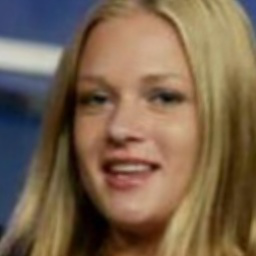

In [21]:
#selecciono 1 ejemplo de la N categoria
N = 7
print(labels[7])
load_img(path_muestra[ejn.iloc[0,N]])

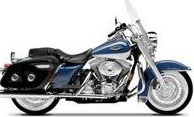

In [65]:
# selecciono 1 ejemplos de 'motorbike'
load_img(path_muestra[ejn['motorbike'][0]])

In [67]:
img = load_img(path_muestra[ejn['motorbike'][0]])

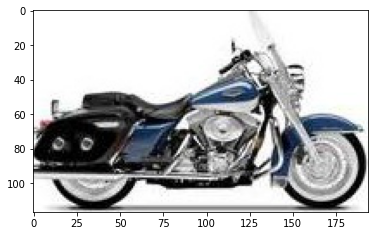

In [73]:
img = np.array(img)
img = np.array(img)
plt.imshow(img)

In [76]:
len(img[0])

194

#### **Atritubos** de **la MUESTRA** del Dataset 


In [ ]:
#Cantidad de imagenes MUESTRA: 1000
len(path_muestra)

1000

In [ ]:
#Etiquetas MUESTRA:
labels = df_labels_m['label'].unique()
print(len(labels), 'labels ->', labels)

8 labels -> ['cat' 'airplane' 'dog' 'flower' 'person' 'car' 'motorbike' 'fruit']


In [ ]:
#Cantidades por Categorías: 
df_labels_m['label'].value_counts(sort = False)

cat          125
airplane     125
dog          125
flower       125
person       125
car          125
motorbike    125
fruit        125
Name: label, dtype: int64

#### **Propiedades** del dataset:
esta compuesto por imagenes de diferentes dimensiones, pero que luego se redimensionan en imagenes de 224 x 224, para homogeneizarlas y asi poder usarlas en los algoritmos de generación de features, clustering etc.

size1: pixeles de alto

size2: pixeles de ancho

vemos en las imagenes a continuación ademas de la diferencia de tamaño, muestra la escala en pixeles de alto y ancho, y se aprecia que son diferentes unos de otro

el dataset se obtuvo de: kaggle.com/datasets/prasunroy/natural-images

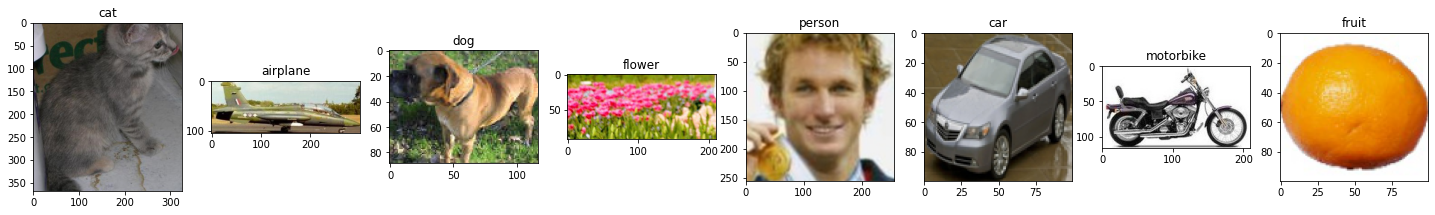

In [ ]:
# 1 Ejemplo de cada categoria --> tienen las imagenes diferentes dimensiones
plt.figure(figsize = (25,25))
for i in range(len(labels)):
  plt.subplot(1,8,i+1)
  img = load_img(path_muestra[ejn.iloc[0,i]])
  img = np.array(img)
  plt.imshow(img)
  plt.title(str(labels[i]))
  #plt.axis('off')  

# 1. **Extracción de features**
Se propone el uso de **un modelo de redes neuronales convolucionales VGG16**, es un **modelo de Transfer Learning que posee 16 capas (con pesos) pre entrenado** para clasificación de imágenes. 

Dicho modelo está **implementado en Keras** https://keras.io/api/applications/vgg/ y por default **trabaja con imágenes de 224x224**.
Este modelo es **entrenado de forma supervisada** para clasificación y **aprende en las capas intermedias** características que son relevante para dicha tarea. En el presente trabajo les proponemos utilizar estas características utilizando la salida de las capas intermdias.

Siguiendo los pasos descriptos en las clases, **explorar el output del modelo y documentar el proceso y las características del mismo**.

Se usa un modelo de Redes Neuronales Convolucionales pre-entrenado con 16 capas, el VGG16 de la libreria keras,  para realizar Transfer Learning.

1) Se redimensionan las imagenes a 224 x 224 pixeles para poder trabajarlas con el modelo VGG16

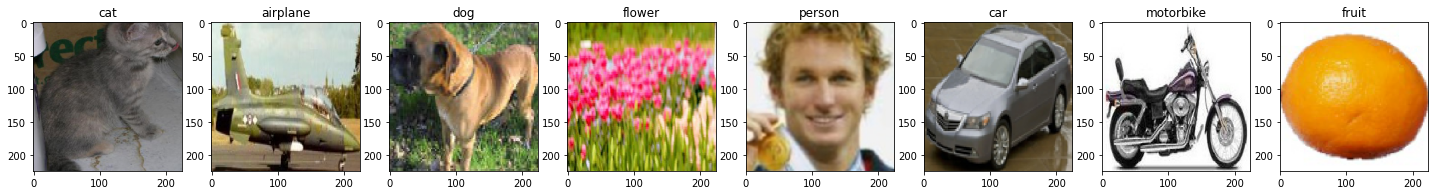

In [ ]:
# 1 Ejemplo de cada categoria --> tienen las imagenes diferentes dimensiones
plt.figure(figsize = (25,25))
for i in range(len(labels)):
  plt.subplot(1,8,i+1)
  img = load_img(path_muestra[ejn.iloc[0,i]], target_size=(224,224))
  img = np.array(img)
  plt.imshow(img)
  plt.title(str(labels[i]))
  #plt.axis('off')  

2) Esas imagenes se transforman en un array y se pasan al formato adecuado para trabajar con un lote de imagenes en keras, el cual es:
(num_samples, size1,size2,channels) -> (1,224, 224, 3)

In [61]:
img = load_img(path_muestra[0], target_size=(224,224))
img = np.array(img)

In [64]:
img[0][0]

array([223, 240, 232], dtype=uint8)

In [39]:
reshaped_img = img.reshape(1,224,224,3)

In [60]:
reshaped_img[0][0][0]

array([223, 240, 232], dtype=uint8)

In [ ]:
#2° -> redimensiona a imagenes a 224x224 -> las redimensiona a un arrar
def extract_features(file, model):
    # levanta imagen como array 224x224 
    img = load_img(file, target_size=(224,224))
    # convierte img a numpy array (originalmente es 'PIL.Image.Image') 
    img = np.array(img) 
    # reshape para tener formato necesario para el modelo (num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepara imagen para modelo (función de keras)
    imgx = preprocess_input(reshaped_img)
    # extrae features
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [ ]:
Levanta archivos y extrae features
names, feat = preprocess(path_muestra, model)

# 2. **Clustering**

## 2.1 KMeans

#### (a) **Aplicar KMeans** sobre el conjuntos de datos 
> con **distintas métricas, normalizaciones, combinaciones**, etc
 
> Determinar la **cantidad de clusters** utilizando **silhuette y SSE.**


Selecciono al azar 1000 imagenes 

In [ ]:
#ya no es necesario --> se creo la muestra --> path_muestra
#random.seed(10)
#path = random.sample(path, 1000)

1/1 [==============================] - 1s 588ms/step


In [ ]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


In [ ]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")


### 2.1.1 KMeans con parametros por default

* init: k-means++
* n_initint =10
* max_iterint= 300
* tolfloat=1e-4
* algorithm=”lloyd”

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_k = [i for i in range(2,20)]
silh = []
sse = []
for k in range_k:
#    KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='k-medoids++').fit(d_meta)
    Kmeans = KMeans(n_clusters=k).fit(x)

    silh.append(silhouette_score(x,Kmeans.labels_))
    sse.append(Kmeans.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

In [ ]:
#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=8, random_state=22)
kmeans.fit(x)

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    

In [ ]:
for n in range(len(groups)):
  view_cluster(groups[n],n)

#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



In [ ]:
from tensorflow.python.eager.context import DEVICE_PLACEMENT_SILENT_FOR_INT32
df_0=pd.DataFrame(groups[0],columns=["path"])
df_0['Labels'] = pd.Series(['dog' for x in range(len(df_0.index))])
df_1=pd.DataFrame(groups[1],columns=["path"])
df_1['Labels'] = pd.Series(['cat' for x in range(len(df_1.index))])
df_2=pd.DataFrame(groups[2],columns=["path"])
df_2['Labels'] = pd.Series(['person' for x in range(len(df_2.index))])
df_3=pd.DataFrame(groups[3],columns=["path"])
df_3['Labels'] = pd.Series(['motorbike' for x in range(len(df_3.index))])
df_4=pd.DataFrame(groups[4],columns=["path"])
df_4['Labels'] = pd.Series(['fruit' for x in range(len(df_4.index))])
df_5=pd.DataFrame(groups[5],columns=["path"])
df_5['Labels'] = pd.Series(['car' for x in range(len(df_5.index))])
df_6=pd.DataFrame(groups[6],columns=["path"])
df_6['Labels'] = pd.Series(['airplane' for x in range(len(df_6.index))])
df_7=pd.DataFrame(groups[7],columns=["path"])
df_7['Labels'] = pd.Series(['flower' for x in range(len(df_7.index))])
df_kmean=pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7])
labelstest = df_kmean["path"].str.split('/',expand=True)
labelstest.columns = ['1', '2', '3','4', '5','6','Labels_test','8']
label_test = labelstest['Labels_test']
df_kmean = pd.concat([df_kmean,label_test], axis=1)
df_kmean

In [ ]:
a= df_kmean[df_kmean['Labels']=='flower']
b=a[a['Labels_test']=='flower']
b

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,8))
labels = ['airplane','car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
cm = confusion_matrix(df_kmean['Labels_test'], df_kmean['Labels'])
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.show()

Indice de rank

In [ ]:
from sklearn.metrics import rand_score
indice_rand= rand_score(df_kmean['Labels_test'], df_kmean['Labels'])
indice_rand

Indice de van dongen

In [ ]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [ ]:
ct = pd.crosstab(df_kmean['Labels_test'], df_kmean['Labels'])
ct


In [ ]:
vanDongen(ct)

#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

In [ ]:
pca = PCA(n_components=2, random_state=22)
pca.fit(x)
x_pca = pca.transform(x)

centroides_sklean_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(x_pca[:, 0], x_pca[:, 1], 
            c=kmeans.labels_, alpha=.25, edgecolor='k')

a=plt.scatter(centroides_sklean_pca[:, 0], centroides_sklean_pca[:, 1], 
            s=200, marker = '*', c='k', edgecolor=None)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.xticks(())
plt.yticks(())


In [ ]:
# Levanta archivos y extrae features --> tarda bastante en correrse --> por eso es que se elige una muestra
names, feat = preprocess(path, model)

In [ ]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


In [ ]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")


#### (d) Discuta brevemente los resultados obtenidos.

conclusiones

### 2.1.2 KMeans combinación de otros parámetros 1

* init: k-means++
* n_initint =20
* max_iterint= 5000
* tolfloat=1e-5
* algorithm=”lloyd”

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_k = [i for i in range(2,20)]
silh = []
sse = []
for k in range_k:
    Kmeans = KMeans(n_clusters=k, random_state=22, n_init=20, max_iter=500, tol=0.00001).fit(x)

    silh.append(silhouette_score(x,Kmeans.labels_))
    sse.append(Kmeans.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

In [ ]:
#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=8, random_state=22, n_init=20, max_iter=500, tol=0.00001)
kmeans.fit(x)

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    

In [ ]:
for n in range(len(groups)):
  view_cluster(groups[n],n)

#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



In [ ]:
from tensorflow.python.eager.context import DEVICE_PLACEMENT_SILENT_FOR_INT32
df_0=pd.DataFrame(groups[0],columns=["path"])
df_0['Labels'] = pd.Series(['flower' for x in range(len(df_0.index))])
df_1=pd.DataFrame(groups[1],columns=["path"])
df_1['Labels'] = pd.Series(['person' for x in range(len(df_1.index))])
df_2=pd.DataFrame(groups[2],columns=["path"])
df_2['Labels'] = pd.Series(['dog' for x in range(len(df_2.index))])
df_3=pd.DataFrame(groups[3],columns=["path"])
df_3['Labels'] = pd.Series(['car' for x in range(len(df_3.index))])
df_4=pd.DataFrame(groups[4],columns=["path"])
df_4['Labels'] = pd.Series(['cat' for x in range(len(df_4.index))])
df_5=pd.DataFrame(groups[5],columns=["path"])
df_5['Labels'] = pd.Series(['airplane' for x in range(len(df_5.index))])
df_6=pd.DataFrame(groups[6],columns=["path"])
df_6['Labels'] = pd.Series(['motorbike' for x in range(len(df_6.index))])
df_7=pd.DataFrame(groups[7],columns=["path"])
df_7['Labels'] = pd.Series(['fruit' for x in range(len(df_7.index))])
df_kmean=pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7])
labelstest = df_kmean["path"].str.split('/',expand=True)
labelstest.columns = ['1', '2', '3','4', '5','6','Labels_test','8']
label_test = labelstest['Labels_test']
df_kmean = pd.concat([df_kmean,label_test], axis=1)
df_kmean

In [ ]:
a= df_kmean[df_kmean['Labels']=='flower']
b=a[a['Labels_test']=='flower']
b

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,8))
labels = ['airplane','car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
cm = confusion_matrix(df_kmean['Labels_test'], df_kmean['Labels'])
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.show()

Indice de rank

In [ ]:
from sklearn.metrics import rand_score
indice_rand= rand_score(df_kmean['Labels_test'], df_kmean['Labels'])
indice_rand

Indice de van dongen

In [ ]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [ ]:
ct = pd.crosstab(df_kmean['Labels_test'], df_kmean['Labels'])
ct


In [ ]:
vanDongen(ct)

#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

In [ ]:
pca = PCA(n_components=2, random_state=22)
pca.fit(x)
x_pca = pca.transform(x)

centroides_sklean_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(x_pca[:, 0], x_pca[:, 1], 
            c=kmeans.labels_, alpha=.25, edgecolor='k')

a=plt.scatter(centroides_sklean_pca[:, 0], centroides_sklean_pca[:, 1], 
            s=200, marker = '*', c='k', edgecolor=None)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.xticks(())
plt.yticks(())


In [ ]:
# Levanta archivos y extrae features
names, feat = preprocess(path, model)

In [ ]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


In [ ]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")


#### (d) Discuta brevemente los resultados obtenidos.

conclusiones

### 2.1.3 KMeans combinación de otros parámetros 1

Tambien se aplica una mayor reducción

In [ ]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=20, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

* init: k-means++
* n_init =20
* max_iter= 300
* tolfloat=1e-4
* algorithm=”lloyd”

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
range_k = [i for i in range(2,20)]
silh = []
sse = []
for k in range_k:
    Kmeans = KMeans(n_clusters=k, random_state=22).fit(x)

    silh.append(silhouette_score(x,Kmeans.labels_))
    sse.append(Kmeans.inertia_)

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()

In [ ]:
#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=8, random_state=22)
kmeans.fit(x)

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(names,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    

In [ ]:
for n in range(len(groups)):
  view_cluster(groups[n],n)

#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



In [ ]:

df_0=pd.DataFrame(groups[0],columns=["path"])
df_0['Labels'] = pd.Series(['cat' for x in range(len(df_0.index))])
df_1=pd.DataFrame(groups[1],columns=["path"])
df_1['Labels'] = pd.Series(['flower' for x in range(len(df_1.index))])
df_2=pd.DataFrame(groups[2],columns=["path"])
df_2['Labels'] = pd.Series(['car' for x in range(len(df_2.index))])
df_3=pd.DataFrame(groups[3],columns=["path"])
df_3['Labels'] = pd.Series(['fruit' for x in range(len(df_3.index))])
df_4=pd.DataFrame(groups[4],columns=["path"])
df_4['Labels'] = pd.Series(['dog' for x in range(len(df_4.index))])
df_5=pd.DataFrame(groups[5],columns=["path"])
df_5['Labels'] = pd.Series(['airplane' for x in range(len(df_5.index))])
df_6=pd.DataFrame(groups[6],columns=["path"])
df_6['Labels'] = pd.Series(['person' for x in range(len(df_6.index))])
df_7=pd.DataFrame(groups[7],columns=["path"])
df_7['Labels'] = pd.Series(['motorbike' for x in range(len(df_7.index))])
df_kmean=pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7])
labelstest = df_kmean["path"].str.split('/',expand=True)
labelstest.columns = ['1', '2', '3','4', '5','6','Labels_test','8']
label_test = labelstest['Labels_test']
df_kmean = pd.concat([df_kmean,label_test], axis=1)
df_kmean

In [ ]:
a= df_kmean[df_kmean['Labels']=='flower']
b=a[a['Labels_test']=='flower']
b

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(15,8))
labels = ['airplane','car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
cm = confusion_matrix(df_kmean['Labels_test'], df_kmean['Labels'])
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)
plt.show()

Indice de rank

In [ ]:
from sklearn.metrics import rand_score
indice_rand= rand_score(df_kmean['Labels_test'], df_kmean['Labels'])
indice_rand

Indice de van dongen

In [ ]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

In [ ]:
ct = pd.crosstab(df_kmean['Labels_test'], df_kmean['Labels'])
ct


In [ ]:
vanDongen(ct)

#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

In [ ]:
pca = PCA(n_components=2, random_state=22)
pca.fit(x)
x_pca = pca.transform(x)

centroides_sklean_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(x_pca[:, 0], x_pca[:, 1], 
            c=kmeans.labels_, alpha=.25, edgecolor='k')

a=plt.scatter(centroides_sklean_pca[:, 0], centroides_sklean_pca[:, 1], 
            s=200, marker = '*', c='k', edgecolor=None)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.xticks(())
plt.yticks(())


#### (d) Discuta brevemente los resultados obtenidos.

Conclusiones:
En los tres variantes propuestas se obtiene muy buenos resultados. Indice de rand superior a 0,99 y indice de van dongen inferior a 0.02. En el caso que se aumento los parametros n_init,max_iter= 300 y disminuir el tol se obtuvieron peores resultados que los valores por default. En el tercer caso se dejaron los parametros por default y se realizó una mayor reducción (20). Dío perores resultados pero de igual modo se obtuvo un buen valor. 

## 2.2 Algoritmo **2** de clustering
En el paso a) considerar los hiper-parámetros y la métrica de validación interna que corresponda.

#### (a) **Aplicar Algoritmo 2 clustering** sobre el conjuntos de datos 
> con **distintas métricas, normalizaciones, combinaciones**, etc
 
> Determinar la **cantidad de clusters****


#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

#### (d) Discuta brevemente los resultados obtenidos.

conclusiones

## 2.3 Algoritmo **3** de clustering
En el paso a) considerar los hiper-parámetros y la métrica de validación interna que corresponda.

#### (a) **Aplicar Algoritmo 3 clustering** sobre el conjuntos de datos 
> con **distintas métricas, normalizaciones, combinaciones**, etc
 
> Determinar la **cantidad de clusters****


#### (b) **Evaluar si el agrupamiento para el k óptimo se condice que las etiquetas de las imágenes**  utilizando:

> la **matriz de confusión** y  

> los **índices de Rand y van Dongen** en los casos que correspondan.



#### c) **Visualizar los clusters y las etiquetas** de género en baja dimensión con **alguna técnica de reducción (PCA, TSNE, MDS, etc)**.

#### (d) Discuta brevemente los resultados obtenidos.

conclusiones

## 2.4 **Comparar** y discutir brevemente los resultados obtenidos.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.filters
import skimage.measure


#### (a) Seleccionar una sóla imagen.

In [ ]:
    # load the image
    image = skimage.io.imread('/content/drive/MyDrive/Colab Notebooks/natural_images/cat/cat_0123.jpg')
    plt.imshow(image)

#### (b) Convertir la imagen a binaria.

In [ ]:

    # convert the image to grayscale
    gray_image = skimage.color.rgb2gray(image)
    # denoise the image with a Gaussian filter
    #blurred_image = skimage.filters.gaussian(gray_image, sigma=2)
    # mask the image according to threshold
    binary_mask = blurred_image < 0.56

    plt.imshow(binary_mask)
    

#### (c) Aplicar los algoritmos de **Connected-component labelling** y **clustering espectral** sobre los pixels.

Connected_component labelling

In [ ]:
# perform connected component analysis
labeled_image, count = skimage.measure.label(binary_mask, connectivity=2, return_num=True)
plt.imshow(labeled_image)

In [ ]:
count

clustering espectral 

#### (d) Describir el proceso y **comparar los resultados** obtenidos.

# 3. **Detección de objetos dentro de una imagen**

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


#### (a) Seleccionar una sóla imagen.

In [ ]:
# Loading the image
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/natural_images/cat/cat_0123.jpg')
cv2_imshow(img)

#### (b) Convertir la imagen a binaria.

In [ ]:
# preprocess the image
gray_img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
# Applying 7x7 Gaussian Blur
blurred = cv2.GaussianBlur(gray_img, (7, 7), 0)
threshold = cv2.threshold(blurred, 0, 125,
    cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cv2_imshow(threshold)

#### (c) Aplicar los algoritmos de **Connected-component labelling** y **clustering espectral** sobre los pixels.

Connected_component labelling

In [ ]:
# Apply the Component analysis function
analysis = cv2.connectedComponentsWithStats(threshold,
                                            4,
                                            cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis
 
# Initialize a new image to
# store all the output components
output = np.zeros(gray_img.shape, dtype="uint8")
 
# Loop through each component
for i in range(1, totalLabels):
   
      # Area of the component
    area = values[i, cv2.CC_STAT_AREA]
     
    if (area > 1400) and (area < 4000000000):
        # Create a new image for bounding boxes
        new_img=img.copy()
         
        # Now extract the coordinate points
        x1 = values[i, cv2.CC_STAT_LEFT]
        y1 = values[i, cv2.CC_STAT_TOP]
        w = values[i, cv2.CC_STAT_WIDTH]
        h = values[i, cv2.CC_STAT_HEIGHT]
         
        # Coordinate of the bounding box
        pt1 = (x1, y1)
        pt2 = (x1+ w, y1+ h)
        (X, Y) = centroid[i]
         
        # Bounding boxes for each component
        cv2.rectangle(new_img,pt1,pt2,
                      (0, 255, 0), 3)
        cv2.circle(new_img, (int(X),
                             int(Y)),
                   4, (0, 0, 255), -1)
 
        # Create a new array to show individual component
        component = np.zeros(gray_img.shape, dtype="uint8")
        componentMask = (label_ids == i).astype("uint8") * 255
 
        # Apply the mask using the bitwise operator
        component = cv2.bitwise_or(component,componentMask)
        output = cv2.bitwise_or(output, componentMask)
         
        # Show the final images
        cv2_imshow(new_img)
        cv2_imshow(component)
        cv2_imshow(output)

clustering espectral 

In [ ]:
from sklearn.feature_extraction import image
mask = threshold.astype(bool)
graph = image.img_to_graph(threshold, mask=mask)

In [ ]:
graph.data = np.exp(-graph.data / graph.data.std())

In [ ]:
graph.shape


tarda 15 minutos

In [ ]:
from sklearn.cluster import spectral_clustering
import matplotlib.pyplot as plt

labels = spectral_clustering(graph, n_clusters=6, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(label_im)

In [ ]:
label_im

In [ ]:
a=np.where((label_im == 0),0.5,-1 )

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(a)

#### (d) Describir el proceso y **comparar los resultados** obtenidos.